# Coral Reef Dataset Exploration
This notebook explores the coral reef dataset by jxwleong (https://www.kaggle.com/datasets/jxwleong/coral-reef-dataset) to evaluate its suitability for machine learning applications in marine conservation. 

This exploration aims to answer the following questions:
* What file formats are used for the data?
* How are annotations stored and what fields do they include?
* Do all images have the same size dimensions?
* What are the color channels?
* What is the label distribution? 
* Is the dataset balanced? If not, how severe is the imbalance?
* Are there ambiguous labels?
* How many annotations exist per image?
* What fraction of pixels are annotated vs. unannotated?
* Are annotations dense (every pixel labeled) or sparse (only specific regions)?
* Are there images with no annotations?
* Is the dataset suitable for developing an AI system for coral monitoring?

In [19]:
# Correct working directory.
# This is necessary for imports because the notebook is not in the main folder of the project.
if not "working_directory_corrected" in vars():
    %cd ..
    working_directory_corrected = True

# Import dependencies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data.dataset import CoralDataset

## 1. Dataset Initialization and Basic Properties
The dataset consists of two parts:
1) A CSV file containing pixel-level labels for the images.
2) A folder containing underwater images of coral reefs.

In [20]:
# Initialize dataset
dataset = CoralDataset()
annotations = dataset.load_annotations()

# Basic statistics
print(f"Total images: {annotations['Name'].nunique()}")
print(f"Total annotations: {len(annotations)}")
print(f"Annotation columns: {list(annotations.columns)}")

# Display sample of annotations
annotations.head()

Total images: 2455
Total annotations: 418310
Annotation columns: ['Name', 'Row', 'Column', 'Label', 'Unnamed: 4']


,Name,Row,Column,Label,Unnamed: 4
0,i0201a.png,111,94,broken_coral_rubble,NaN
1,i0201a.png,173,243,broken_coral_rubble,NaN
2,i0201a.png,84,366,broken_coral_rubble,NaN
3,i0201a.png,54,802,broken_coral_rubble,NaN
4,i0201a.png,313,66,sand,NaN


There are 4505 in the images folder, while we have 2455 images recorded in the CSV file.

The CSV file contains 418310 entries and records these features:
- **Name**: Filename of the corresponding coral image.
- **Row**: Vertical coordinate of the annotated pixel (0 = top of image).
- **Column**: Horizontal coordinate of the annotated pixel (0 = left edge).
- **Label**: Ecological classification of the coral at this location.
- **Unnamed: 4**: An empty column that can be safely ignored.

This structure suggests a sparse sampling strategy where ecologically significant points are labeled rather than full segmentation masks.

In [21]:
print(f"Average annotations per image: {len(annotations)/annotations['Name'].nunique():.1f}")

Average annotations per image: 170.4


Initial observations show: 
- There are images in the dataset that have not been annotated, and may need to be removed. 
- With 418,310 annotations across 2,455 images, we have approximately 170 annotated points per image on average.
- The Row/Column values represent a discrete sampling approach rather than full segmentation masks.
- Multiple classes are present within single images (as seen in the first five rows showing both 'broken_coral_rubble' and 'sand'). 

This point-based annotation strategy differs from more common bounding box approaches, and will probably influence the model selection stage later on.

## 2. Image Data Properties
Before examining the label distribution, we should understand the properties of the image data. 
By manual inspection of the image data we can identify:
* The images have different dimensions.
* The images come in two formats: .png and .jpg.

Having different dimensions and formats indicate some adjustments will be needed. 
An illustration is shown below:

In [22]:
# Get unique image names from annotations
sampled_images = annotations['Name'].sample(n=10, random_state=42)
# Print image properties
for img_name in sampled_images:
    try: 
        img = dataset.get_image(img_name)
        img_data = np.array(object=img)
        print(f"{img_name}:", img_data.shape)
    except Exception as err:
        print(f"Error processing {img_name}: {err}")

mcr_lter5_out17m_pole1-2_qu7_20090410.jpg: (1984, 2035, 3)
mcr_lter1_fringingreef_pole1-2_qu8_20100411.jpg: (1920, 1916, 3)
mcr_lter3_out10m_pole3-4_qu2_20100407.jpg: (1836, 1740, 3)
mcr_lter1_out10m_pole4-5_qu8_20090330.jpg: (1992, 2124, 3)
mcr_lter1_fringingreef_pole2-3_qu2_20080415.jpg: (1948, 1948, 3)
o0317b.png: (792, 976, 4)
mcr_lter2_out17m_pole5-6_qu7_20100406.jpg: (1872, 1852, 3)
mcr_lter2_fringingreef_pole4-5_qu3_20090402.jpg: (1983, 2107, 3)
mcr_lter3_fringingreef_pole3-4_qu1_20080503.jpg: (1928, 1912, 3)
mcr_lter3_out17m_pole1-2_qu7_20090406.jpg: (1918, 1849, 3)


We can confirm the images have different dimensions and formats (one image in the sample has a .png extension). In addition, the png image has four color channels as opposed to the three channels in the jpg images. 

## 3. Tabular Data Properties
Next, we will explore the tabular dataset (CSV file).

In [23]:
# Check for any missing values
print("Missing Names:", annotations["Name"].isna().sum())
print("Missing Rows:", annotations["Row"].isna().sum())
print("Missing Columns:", annotations["Column"].isna().sum())
print("Missing Labels:", annotations["Label"].isna().sum())

# Check if the 'Unnamed: 4' column contains anything
print("Non-null values in Unnamed: 4:", annotations["Unnamed: 4"].notna().sum())

Missing Names: 0
Missing Rows: 0
Missing Columns: 0
Missing Labels: 0
Non-null values in Unnamed: 4: 0


Since there are no missing values, this will not be an issue during data processing. The Unnamed: 4 column can also be safely removed to clean up the data. 

We can now check the label distribution to see how balanced the dataset is.

Label distribution statistics:
                           Count  Percentage
Label                                       
crustose_coralline_algae  226017       54.03
turf                       43769       10.46
sand                       38880        9.29
porites                    35236        8.42
macroalgae                 23832        5.70
off                        13605        3.25
pocillopora                11319        2.71
montipora                   8755        2.09
pavona                      5806        1.39
acropora                    3458        0.83
hard_substrate              2086        0.50
millepora                   1459        0.35
broken_coral_rubble         1025        0.25
montastraea                  645        0.15
leptastrea                   528        0.13
soft                         280        0.07
bad                          259        0.06
goniastrea                   198        0.05
dark                         191        0.05
fungia                  

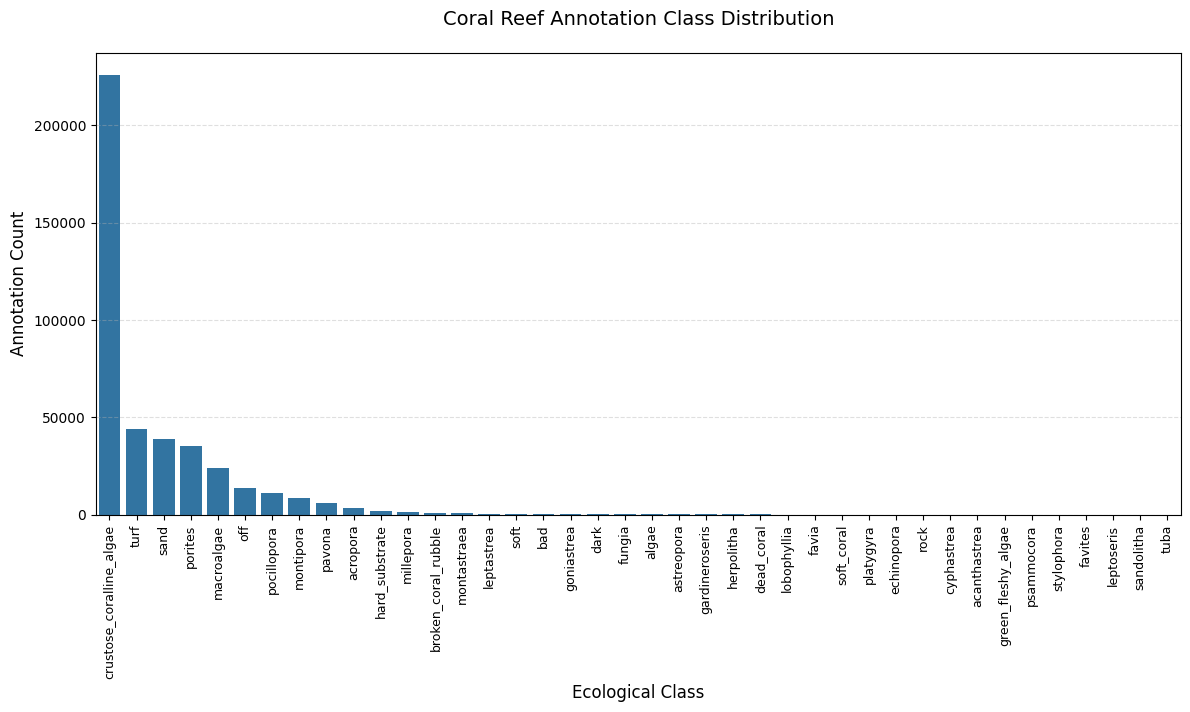

In [ ]:
# Calculate label distribution
label_dist = annotations['Label'].value_counts()
total_annotations = len(annotations)

# Convert to percentages
label_percent = (label_dist / total_annotations * 100).round(2)

# Combine into summary dataframe
label_stats = pd.DataFrame({
    'Count': label_dist,
    'Percentage': label_percent
})

print("Label distribution statistics:")
print(label_stats)

# Get class extremes
majority_class = label_dist.idxmax()
minority_class = label_dist.idxmin()
num_classes = len(label_dist)

print(f"Total classes: {num_classes}")
print(f"Majority class: '{majority_class}' with {label_dist.max():,} annotations")
print(f"Minority class: '{minority_class}' with {label_dist.min()} annotation")
print(f"Annotations covering 95% of data: {label_stats[label_stats['Percentage'].cumsum() <= 95].shape[0]} classes")

# Plot configuration
plt.figure(figsize=(14, 6))
ax = sns.barplot(x=label_dist.index, y=label_dist.values)

# Formatting
plt.title('Coral Reef Annotation Class Distribution', pad=20, fontsize=14)
plt.xlabel('Ecological Class', fontsize=12)
plt.ylabel('Annotation Count', fontsize=12)
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=10)

# Add grid
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


The dataset contains annotations of 40 distinct ecological classes, ranging from coral species to abiotic classes (e.g. "sand" and "rock"). The diversity can be an opportunity for reporting on coral health using various indicators, but the extreme class imbalance presents a major challenge. The majority class: 'crustose_coralline_algae' makes up 54% of all annotations, while the minority class: 'tuba' only has 1 annotation. The top 7 classes are covering 95% of the data. In addition, some classes seem ambiguous (e.g.'off') and need to be inspected further to identify what they represent. 
Some actions could be taken to tackle this issue: 
* Class grouping strategies: 
    * We can merge rare coral species into higher taxa or merge all coral species into 'healthy_coral'.
    * We can merge "sand", "rock", "hard_substrate" into 'abiotic_class'.
* Add another dataset to use with this one (e.g. https://coralnet.ucsd.edu/source/5546/browse/images/).
* Transfer learning: 
* Hierarchical modeling: 

